To collect data from YouTube, we need to be clear about what data we need. Let’s collect data about the trending videos on YouTube to analyze and find what makes a video trend on YouTube.

So, let’s start with data collection first. To collect data from YouTube, you need to set up an API. Here are the steps you can follow:

Go to Google Cloud Console.
Click on the project drop-down at the top, then “New Project”.
Enter a project name and click “Create”.
In the Google Cloud Console, navigate to “APIs & Services” > “Library”.
Search for “YouTube Data API v3” and click on it.
Click “Enable”.
Go to “APIs & Services” > “Credentials”.
Click “+ CREATE CREDENTIALS” and select “API key”.
Copy the generated API key.

In [1]:
import pandas as pd
from googleapiclient.discovery import build

In [46]:
#replace with your own API key
API_KEY = 'YOUR API KEY'

In [5]:
def get_trending_videos(api_key, max_results=200):
  #build the youtube service
  youtube = build('youtube', 'v3', developerKey=api_key)

  #initialize the list to hold video details
  videos = []

  #fetch the most popular videos
  request = youtube.videos().list(
      part='snippet, contentDetails, statistics',
      chart='mostPopular',
      regionCode='US',
      maxResults=50
  )

  #paginate through the results if max_results >50
  while request and len(videos) < max_results:
    response = request.execute()
    for item in response['items']:
      video_details = {
          'video_id': item['id'],
          'title': item['snippet']['title'],
          'description': item['snippet']['description'],
          'published_at': item['snippet']['publishedAt'],
          'channel_id': item['snippet']['channelId'],
          'channel_title': item['snippet']['channelTitle'],
          'category_id': item['snippet']['categoryId'],
          'tags': item['snippet'].get('tags',[]),
          'duration':item['contentDetails']['duration'],
          'definition':item['contentDetails']['definition'],
          'caption' : item['contentDetails'].get('caption','false'),
          'view_count': item['statistics'].get('viewCount',0),
          'like_count': item['statistics'].get('likeCount',0),
          'dislike_count':item['statistics'].get('dislikeCount',0),
          'favorite_count':item['statistics'].get('favoriteCount',0),
          'comment_count': item['statistics'].get('commentCount',0)
      }

      videos.append(video_details)

    #get the next page token
    request = youtube.videos().list_next(request, response)

  return videos[:max_results]

def save_to_csv(data, filename):
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)

def main():
  trending_videos = get_trending_videos(API_KEY)
  filename = 'trending_videos.csv'
  save_to_csv(trending_videos, filename)
  print(f'Trending videos saved to {filename}')

if __name__ == '__main__':
  main()

Trending videos saved to trending_videos.csv


In the above code, we are using the YouTube Data API to fetch details of the top 200 trending videos in the US, iterating through the API’s paginated responses to collect video details such as title, description, published date, channel information, tags, duration, definition, captions, and various engagement metrics like views, likes, and comments. The script compiles this information into a list, converts it into a pandas DataFrame, and saves the data to a CSV file named trending_videos.csv, allowing us to analyze trends and patterns in the collected video data.

Now, let’s have a look at what the data looks like:

In [6]:
trending_videos = pd.read_csv('trending_videos.csv')
print(trending_videos.head())

      video_id                                              title  \
0  YRSbrJAqqQw   Germany vs. Scotland Highlights | UEFA Euro 2024   
1  mp88N6ItZko                                   My Criminal Dogs   
2  f5DkKJdJs9Q           𝗣UNCH PUNCH FOREVER! - My Little Slasher   
3  DVSj3K_skJg  Argentina 4-1 Guatemala | Extended Game Highli...   
4  _dlwIHgSAZw      Portal but I softlock myself on every chamber   

                                         description          published_at  \
0  Check out the top moments from this group-stag...  2024-06-14T21:27:08Z   
1  Which dog is your favorite? (There is only one...  2024-06-14T16:00:06Z   
2  Episode 2 of 𝗣𝗨𝗡𝗖𝗛 𝗣𝗨𝗡𝗖𝗛 𝗙𝗢𝗥𝗘𝗩𝗘𝗥!\nWatch episo...  2024-06-14T20:00:07Z   
3  Argentina vs Guatemala Match recap | The Argen...  2024-06-15T02:38:11Z   
4  First playthrough of Portal. I am determined t...  2024-06-14T21:52:22Z   

                 channel_id channel_title  category_id  \
0  UCooTLkxcpnTNx6vfOovfBFA    FOX Soccer           17   


Now, let’s have a quick look at the missing values and data types:

In [10]:
#check for missing values
missing_values = trending_videos.isnull().sum()

#display data types
data_types = trending_videos.dtypes

missing_values, data_types

(video_id          0
 title             0
 description       1
 published_at      0
 channel_id        0
 channel_title     0
 category_id       0
 tags              0
 duration          0
 definition        0
 caption           0
 view_count        0
 like_count        0
 dislike_count     0
 favorite_count    0
 comment_count     0
 dtype: int64,
 video_id          object
 title             object
 description       object
 published_at      object
 channel_id        object
 channel_title     object
 category_id        int64
 tags              object
 duration          object
 definition        object
 caption             bool
 view_count         int64
 like_count         int64
 dislike_count      int64
 favorite_count     int64
 comment_count      int64
 dtype: object)

The description column has 4 missing values. This is minor and can be handled as needed. The data types seem appropriate for most columns, but we may need to convert the published_at column to a datetime format and tags might need further processing. Let’s fix these changes:

In [14]:
#fill missing descriptions with "No description"

trending_videos['description'].fillna('No description', inplace=True)

#convert `published_at` to datetime
trending_videos['published_at'] = pd.to_datetime(trending_videos['published_at'])

#convert tags from string representation of list to actual list
trending_videos['tags'] = trending_videos['tags'].apply(lambda x: eval(x) if isinstance(x,str) else x)


Now, before moving forward with the analysis, let’s have a quick look at the descriptive statistics:

In [16]:
#descritive statistics
descriptive_stats = trending_videos[['view_count', 'like_count', 'dislike_count', 'comment_count']].describe()

descriptive_stats

,view_count,like_count,dislike_count,comment_count
count,2.000000e+02,2.000000e+02,200.0,200.000000
mean,2.243241e+06,8.406230e+04,0.0,5651.200000
std,7.043670e+06,2.895053e+05,0.0,17439.575998
min,5.639000e+04,0.000000e+00,0.0,0.000000
25%,3.563215e+05,1.509400e+04,0.0,887.250000
50%,6.058935e+05,2.599750e+04,0.0,1824.500000
75%,1.188126e+06,5.388575e+04,0.0,4763.500000
max,7.160825e+07,3.444951e+06,0.0,207877.000000


Now, let’s have a look at the distribution of views, likes and comments of all the videos in the data:

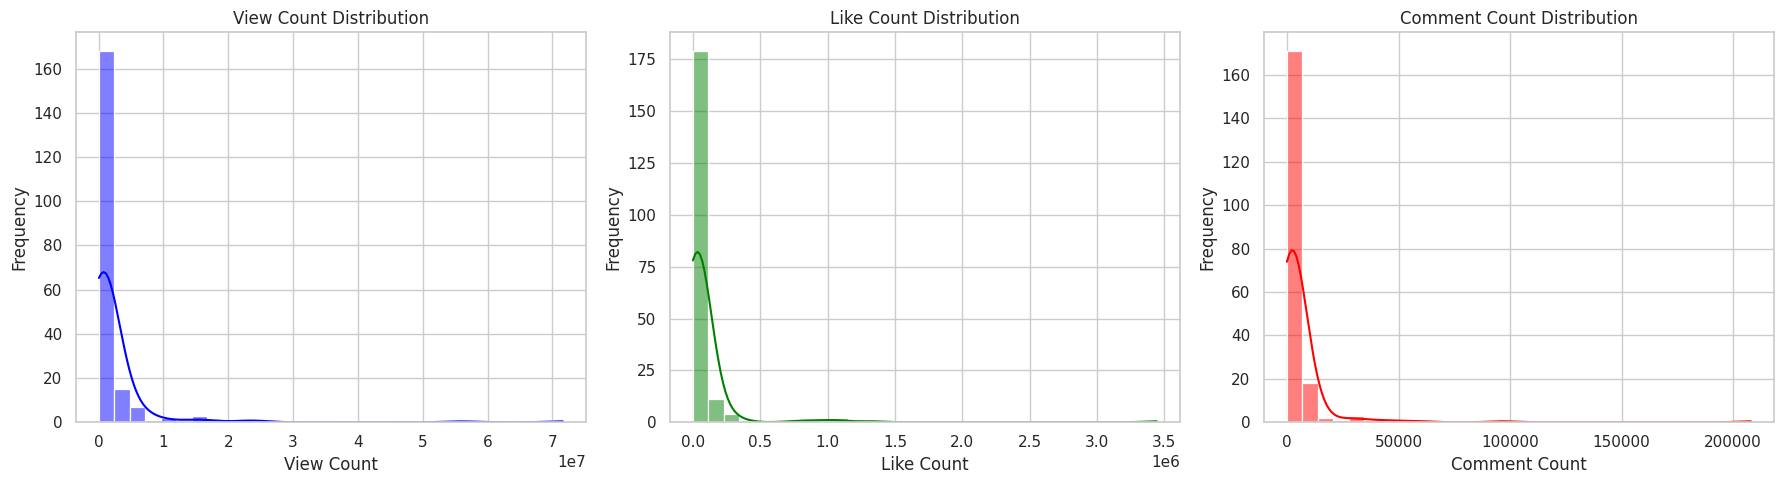

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

fig, axes = plt.subplots(1,3, figsize=(18,5))

#view count distribution
sns.histplot(trending_videos['view_count'], bins=30, kde=True,ax=axes[0], color='blue' )
axes[0].set_title('View Count Distribution')
axes[0].set_xlabel('View Count')
axes[0].set_ylabel('Frequency')

# like count distribution
sns.histplot(trending_videos['like_count'], bins=30, kde=True, ax=axes[1], color='green')
axes[1].set_title('Like Count Distribution')
axes[1].set_xlabel('Like Count')
axes[1].set_ylabel('Frequency')

# comment count distribution
sns.histplot(trending_videos['comment_count'], bins=30, kde=True, ax=axes[2], color='red')
axes[2].set_title('Comment Count Distribution')
axes[2].set_xlabel('Comment Count')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

The histograms show that the distributions of view counts, like counts, and comment counts are right-skewed, with most videos having lower counts and a few videos having very high counts. Now, let’s have a look at the correlation between likes, views, and comments

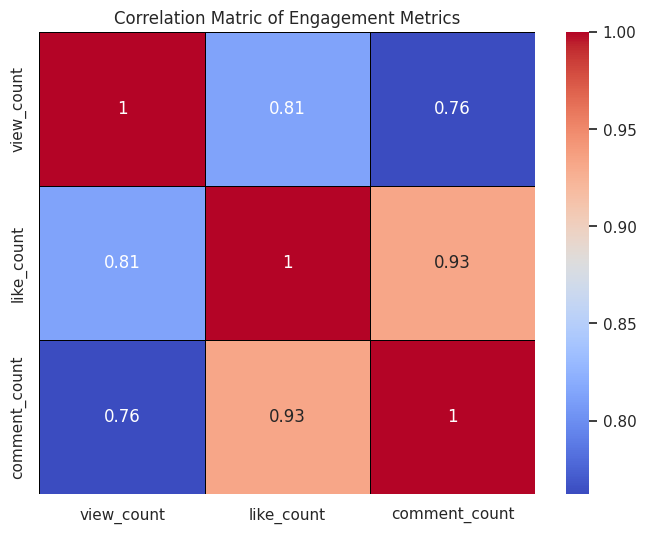

In [25]:
#correlation matrix
correlation_matrix = trending_videos[['view_count','like_count', 'comment_count']].corr()


plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black')
plt.title('Correlation Matric of Engagement Metrics')
plt.show()

The heatmap confirms strong positive correlations between views, likes, and comments.

I noticed that I only collected the category ID of the video and not the category name. So, let’s collect the category names as well to analyze the categories of the trending videos:

In [28]:
from googleapiclient.discovery import build

API_KEY = 'YOUR API KEY '
youtube = build('youtube', 'v3', developerKey=API_KEY)

def get_category_mapping():
    request = youtube.videoCategories().list(
        part='snippet',
        regionCode='US'
    )
    response = request.execute()
    category_mapping = {}
    for item in response['items']:
        category_id = int(item['id'])
        category_name = item['snippet']['title']
        category_mapping[category_id] = category_name
    return category_mapping

# get the category mapping
category_mapping = get_category_mapping()
print(category_mapping)

{1: 'Film & Animation', 2: 'Autos & Vehicles', 10: 'Music', 15: 'Pets & Animals', 17: 'Sports', 18: 'Short Movies', 19: 'Travel & Events', 20: 'Gaming', 21: 'Videoblogging', 22: 'People & Blogs', 23: 'Comedy', 24: 'Entertainment', 25: 'News & Politics', 26: 'Howto & Style', 27: 'Education', 28: 'Science & Technology', 29: 'Nonprofits & Activism', 30: 'Movies', 31: 'Anime/Animation', 32: 'Action/Adventure', 33: 'Classics', 34: 'Comedy', 35: 'Documentary', 36: 'Drama', 37: 'Family', 38: 'Foreign', 39: 'Horror', 40: 'Sci-Fi/Fantasy', 41: 'Thriller', 42: 'Shorts', 43: 'Shows', 44: 'Trailers'}


Now, here’s how we can analyze the number of trending videos by category:

<ipython-input-30-06c32c129ece>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=trending_videos['category_name'], order=trending_videos['category_name'].value_counts().index,palette='viridis')


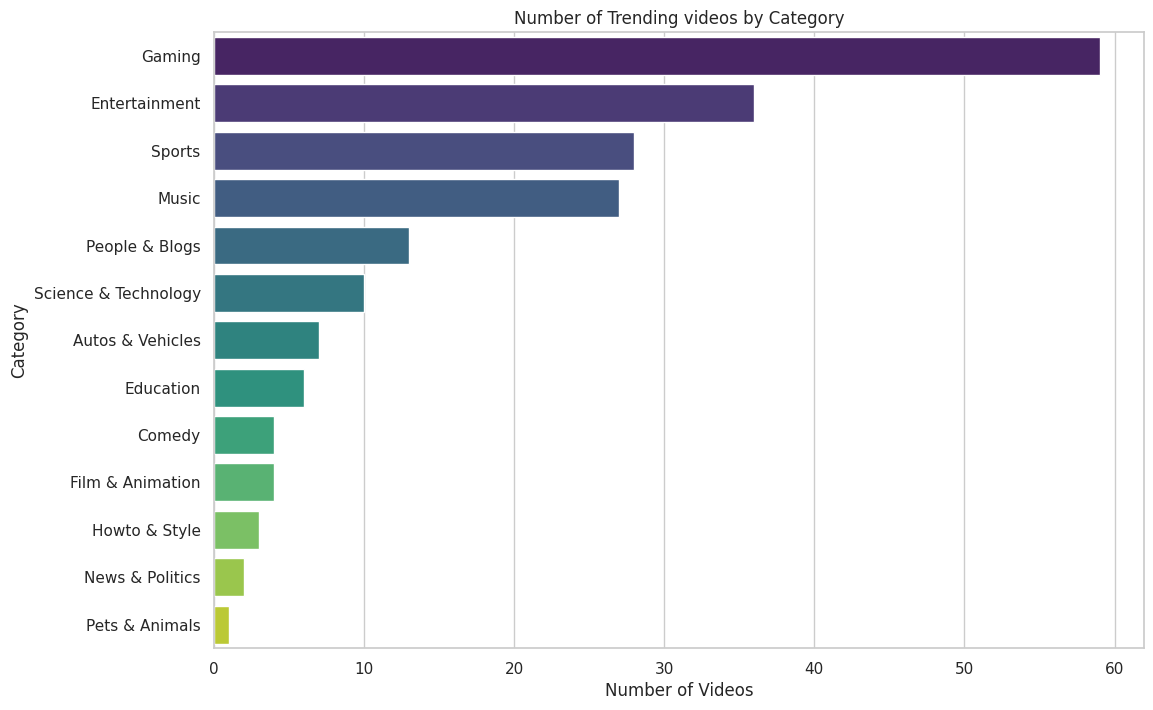

In [30]:
trending_videos['category_name'] = trending_videos['category_id'].map(category_mapping)

#Bar chart for category counts
plt.figure(figsize=(12,8))
sns.countplot(y=trending_videos['category_name'], order=trending_videos['category_name'].value_counts().index,palette='viridis')
plt.title('Number of Trending videos by Category')
plt.xlabel('Number of Videos')
plt.ylabel('Category')
plt.show()

The bar chart shows that the Gaming, Entertainment, Sports, and Music categories have the highest number of trending videos. Now, let’s have a look at the average engagement metrics by category:

<ipython-input-32-e768c19952f4>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=category_engagement.index, x=category_engagement['view_count'],ax=axes[0], palette='viridis')
<ipython-input-32-e768c19952f4>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=category_engagement.index, x=category_engagement['like_count'], ax=axes[1], palette='viridis')
<ipython-input-32-e768c19952f4>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=category_engagement.index, x=category_engagement['comment_count'], ax=axes[2], palette='viridis')


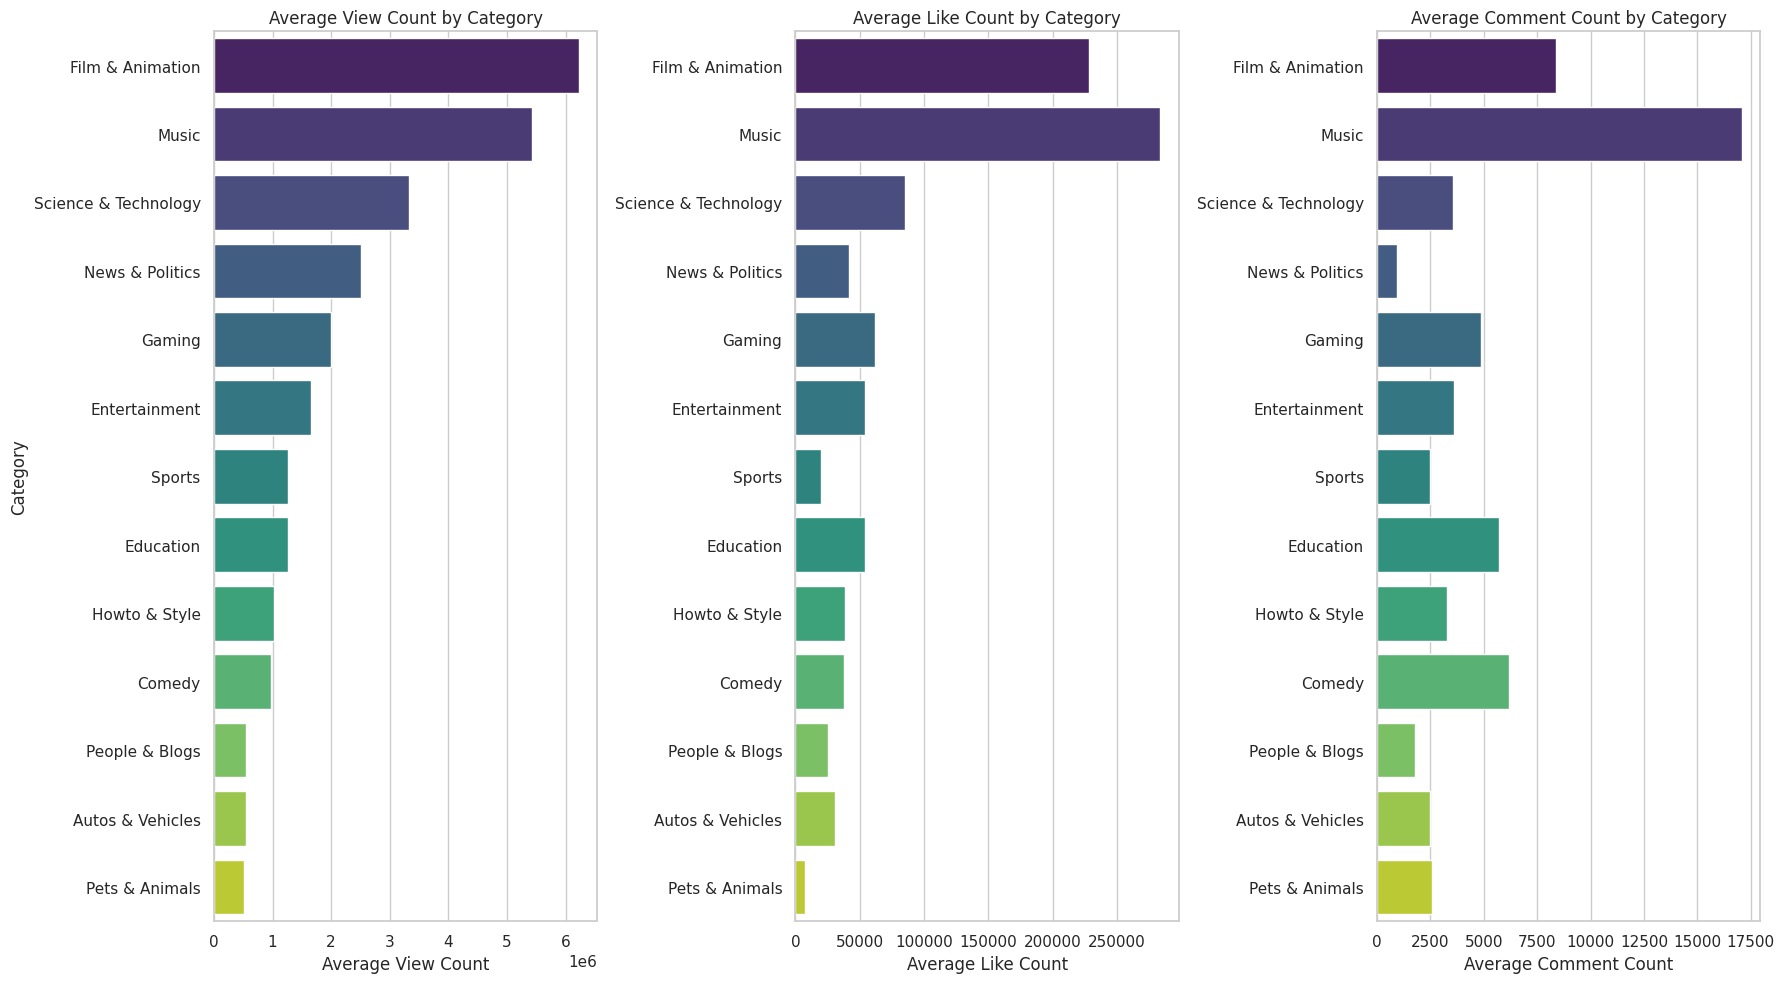

In [32]:
#Average engagement metrics by category
category_engagement = trending_videos.groupby('category_name')[['view_count', 'like_count','comment_count']].mean().sort_values(by='view_count',ascending=False)

fig, axes = plt.subplots(1,3, figsize=(18,10))

#view count by category
sns.barplot(y=category_engagement.index, x=category_engagement['view_count'],ax=axes[0], palette='viridis')
axes[0].set_title('Average View Count by Category')
axes[0].set_xlabel('Average View Count')
axes[0].set_ylabel('Category')

#like count by category
sns.barplot(y=category_engagement.index, x=category_engagement['like_count'], ax=axes[1], palette='viridis')
axes[1].set_title('Average Like Count by Category')
axes[1].set_xlabel('Average Like Count')
axes[1].set_ylabel('')

# comment count by category
sns.barplot(y=category_engagement.index, x=category_engagement['comment_count'], ax=axes[2], palette='viridis')
axes[2].set_title('Average Comment Count by Category')
axes[2].set_xlabel('Average Comment Count')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

Now, let’s analyze the content and duration of the videos. But first, we need to convert the duration from ISO 8601 format to seconds:

In [33]:
!pip install isodate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 688.3 kB/s eta 0:00:00


In [34]:
import isodate

#convert ISO 8601 duration to seconds
trending_videos['duration_seconds'] = trending_videos['duration'].apply(lambda x: isodate.parse_duration(x).total_seconds())

trending_videos['duration_range'] = pd.cut(trending_videos['duration_seconds'], bins=[0,300,600,1200,3600,7200], labels=['0-5 min', '5-10 min', '10-20 min', '20-60 min', '60-120 min'])

Now, let’s analyze the content and the duration of videos:

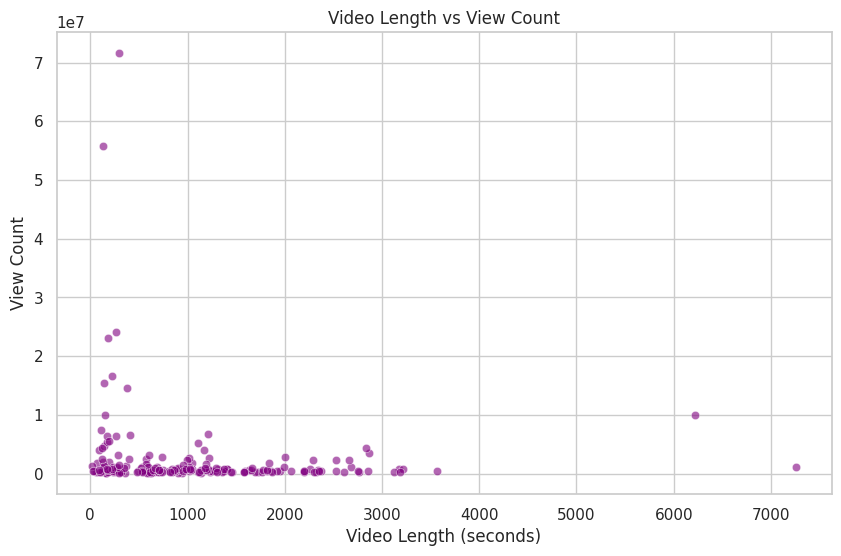

<ipython-input-43-071672337da8>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=length_engagement.index, x=length_engagement['view_count'], ax=axes[0], palette='magma')
<ipython-input-43-071672337da8>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=length_engagement.index, x=length_engagement['like_count'], ax=axes[1], palette='magma')
<ipython-input-43-071672337da8>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=length_engagement.index, x=length_engagement['comment_count'], ax=axes[2], palette='magma')


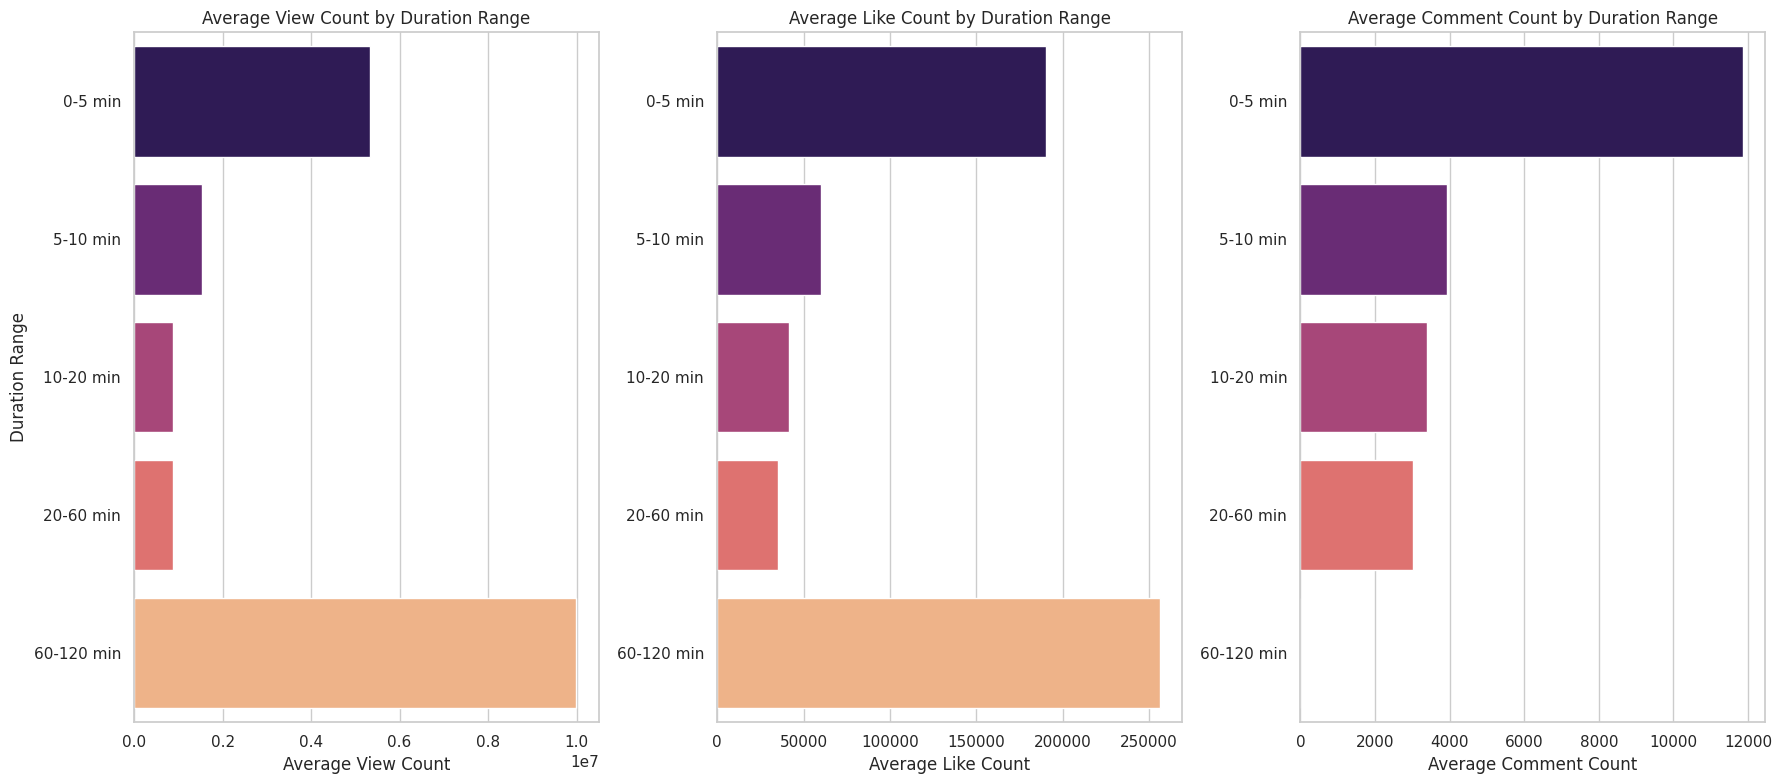

In [43]:
# scatter plot for video length vs view count
plt.figure(figsize=(10, 6))
sns.scatterplot(x='duration_seconds', y='view_count', data=trending_videos, alpha=0.6, color='purple')
plt.title('Video Length vs View Count')
plt.xlabel('Video Length (seconds)')
plt.ylabel('View Count')
plt.show()

# bar chart for engagement metrics by duration range
length_engagement = trending_videos.groupby('duration_range')[['view_count', 'like_count', 'comment_count']].mean()

fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# view count by duration range
sns.barplot(y=length_engagement.index, x=length_engagement['view_count'], ax=axes[0], palette='magma')
axes[0].set_title('Average View Count by Duration Range')
axes[0].set_xlabel('Average View Count')
axes[0].set_ylabel('Duration Range')

# like count by duration range
sns.barplot(y=length_engagement.index, x=length_engagement['like_count'], ax=axes[1], palette='magma')
axes[1].set_title('Average Like Count by Duration Range')
axes[1].set_xlabel('Average Like Count')
axes[1].set_ylabel('')

# comment count by duration range
sns.barplot(y=length_engagement.index, x=length_engagement['comment_count'], ax=axes[2], palette='magma')
axes[2].set_title('Average Comment Count by Duration Range')
axes[2].set_xlabel('Average Comment Count')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

Now, let’s analyze the relationship between views and number of tags used in the video:

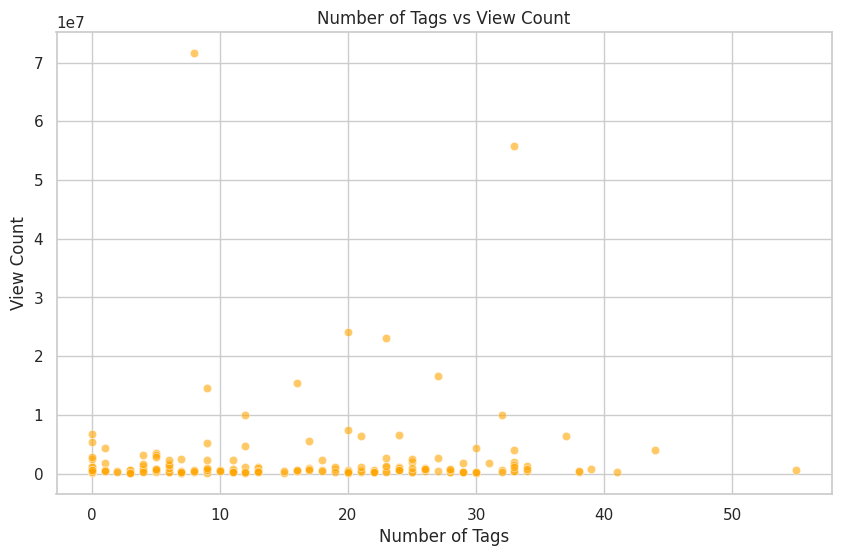

In [44]:
#calculate the number of tags for each video
trending_videos['tag_count'] = trending_videos['tags'].apply(len)

#scatter plot for number of tags Vs view count
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tag_count', y='view_count', data=trending_videos, alpha=0.6, color='orange')
plt.title('Number of Tags vs View Count')
plt.xlabel('Number of Tags')
plt.ylabel('View Count')
plt.show()

The scatter plot shows a very weak relationship between the number of tags and view count, suggesting that the number of tags has minimal impact on a video’s view count.

Now, let’s see if there’s an impact of the time a video is posted on its views:

<ipython-input-45-45ea5fa226af>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='publish_hour', data=trending_videos, palette='coolwarm')


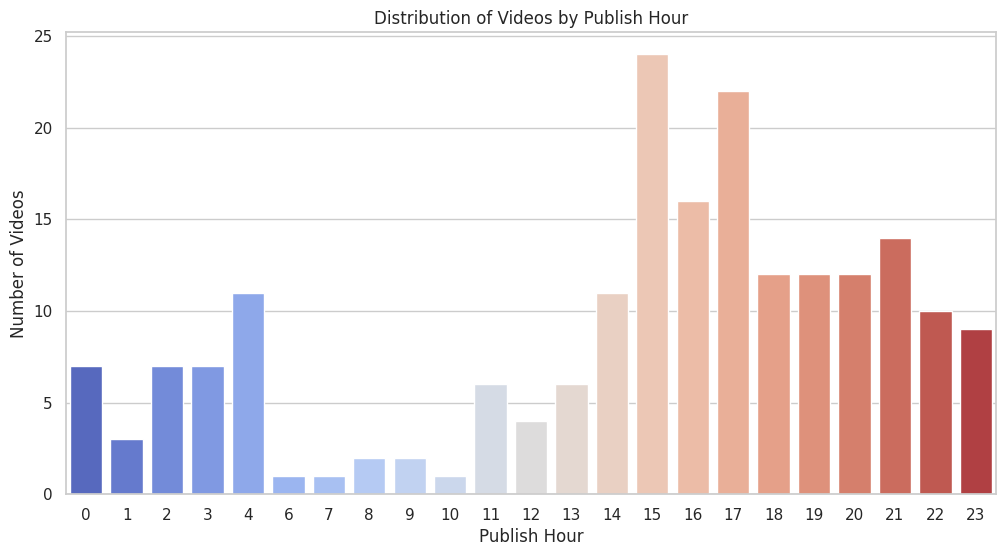

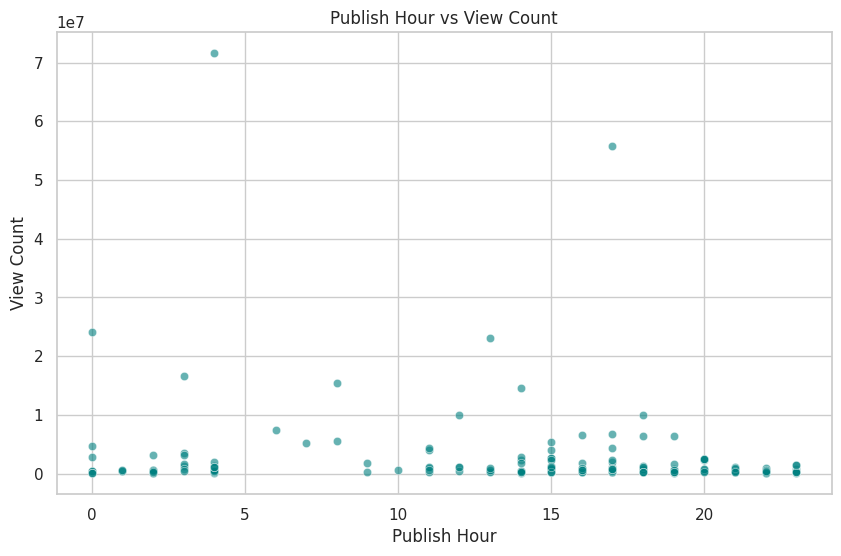

In [45]:
#extract hour of publication
trending_videos['publish_hour'] = trending_videos['published_at'].dt.hour


#bar chart for publish hour distribution
plt.figure(figsize=(12,6))
sns.countplot(x='publish_hour', data=trending_videos, palette='coolwarm')
plt.title('Distribution of Videos by Publish Hour')
plt.xlabel('Publish Hour')
plt.ylabel('Number of Videos')
plt.show()

# scatter plot for publish hour vs view count
plt.figure(figsize=(10, 6))
sns.scatterplot(x='publish_hour', y='view_count', data=trending_videos, alpha=0.6, color='teal')
plt.title('Publish Hour vs View Count')
plt.xlabel('Publish Hour')
plt.ylabel('View Count')
plt.show()

The distribution shows that most videos are published between 15:00 and 21:00 hours (3 PM – 9 PM), indicating this may be an optimal time for uploading videos. There is a very weak negative relationship between publish hour and view count, suggesting that the hour of publication has minimal impact on engagement metrics.

# **Conclusion**

Encourage viewers to like and comment on videos to boost engagement metrics.

Aim to create shorter videos (under 5 minutes) for higher engagement, especially for categories like Music and Entertainment.

Schedule video uploads around peak times (3 PM – 9 PM) to maximize initial views and engagement.